<font size="3" color='blue'> ASM Golam Sarwar</font>
<nav>
<a href=”https://www.linkedin.com/in/asm-golam-sarwar/">LinkedIn</a>
</nav>

This document splited into 2 sections, Feature engineering and Modeling(Predict the dafult). Feature engineering section we'll try to find out the significance of the features towards the outcome which is Default and if it found relevent to the outcome we'll keep that feature for final prediction model else discard.

# Problem Statement

In the financial industry, accurately predicting the likelihood of customer loan default is paramount to mitigate risks and ensure the stability of lending operations. Organization's possesses a comprehensive customer dataset that includes historical loan application information, customer demographics, credit history, and previous default records.

The objective of this project is to develop a predictive model that can effectively identify customers who are at a higher risk of defaulting on their loans. By leveraging advanced machine learning techniques and the wealth of data, we aim to achieve the following goals:

<font size="2" color='blue'> **Risk Assessment**</font>: Create a predictive model that assesses the probability score indicating the likelihood of default for each customer.

<font size="2" color='blue'> **Default Identification**</font>: Implement a classification model that accurately categorizes customers into "default" and "non-default" groups based on predefined criteria. This will enable timely intervention and risk management strategies for high-risk customers.

<font size="2" color='blue'> **Model Explainability**</font>: Ensure transparency and interpretability of the predictive model, allowing us to understand the key factors influencing default predictions and providing actionable insights for decision-makers.

<font size="2" color='blue'> **Performance Metrics**</font>: Establish rigorous performance evaluation metrics, including precision, recall, F1-score, and ROC AUC, to measure the effectiveness of the model in differentiating defaulting customers from non-defaulting ones.

<font size="2" color='blue'> **Scalability**</font>: Design the solution to be scalable and adaptable to accommodate an ever-growing dataset and evolving customer behaviors.

By addressing this problem, we aim to enhance the risk assessment capabilities, reduce loan default rates, and ultimately optimize our lending processes, resulting in improved financial stability and customer satisfaction.

## Below are some of the columns would have strong co-relation being a defaulter. however, most of the rows doesn't have any values. Hence need to exclude them in the subsequent process  

<font size="2" color='red'> **annual_income**</font> - Zero values | less than 100 values | currency missing  

<font size="2" color='red'> **current_ca_credit_limit**</font> (current account credit limit) - 96% missing value  
<font size="2" color='red'> **current_cp_credit_limit**</font> (Cash product credit limit)    - 96% missing value  

<font size="2" color='red'> **initial_ca_credit_limit**</font> - 97% missing value  
<font size="2" color='red'> **initial_cp_credit_limit**</font> - 97% missing value

<font size="2" color='red'> **credit_card_branch_location**</font> - corelation with default



# Import required library

In [3]:
import pandas as pd
import os
import numpy as np
from datetime import datetime as dt

# Custom functions

In [23]:
import scipy.stats as scp_stat


## Calculating the lift of the feature

In [115]:
# Lift calculation
# Definition : Lift is a measure of the effectiveness of a predictive model in identifying a specific category. 
#              It quantifies how many times more likely the model is to correctly identify the category compared to random chance. 
#              A lift value greater than 1 indicates that the model or campaign is significant in targeting the category of interest, 
#              with higher values indicating greater significance

def calc_lift(dataframe,target_variable,output,out_true_value=True,out_false_value=False,sign=1):
 
    average_data          = dataframe.groupby(output).count().reset_index()#.toPandas()

    try:
        out_true_value_count  = average_data[target_variable][average_data[output]==out_true_value].tolist()[0]
    except:
        out_true_value_count = 0
    try:
        out_false_value_count = average_data[target_variable][average_data[output]==out_false_value].tolist()[0]
    except:
        out_false_value_count = 0
    
    ## output average
    try:
        average_output = (float(out_true_value_count)/float(out_true_value_count+out_false_value_count))*100
    except:
        average_output = 0
    
    try:
        target_variable_unique_value = dataframe[~dataframe[target_variable].isnull()][target_variable].sort_values().unique().tolist()
    except:
        target_variable_unique_value = 0
    
    groupby_tar_out = dataframe.groupby([target_variable,output]).count().reset_index()
 

    result = []
    
    for variable in target_variable_unique_value:
        
        #print(variable)
        
        target_variable_data_output_true = groupby_tar_out['customer_id']\
                                    [(groupby_tar_out[target_variable]==variable)\
                                     &(groupby_tar_out[output]==out_true_value)].tolist()[0]
   
        target_variable_data_output_false = groupby_tar_out['customer_id']\
                                    [(groupby_tar_out[target_variable]==variable)\
                                     &(groupby_tar_out[output]==out_false_value)].tolist()[0]
   
        target_variable_average = (float(target_variable_data_output_true)/\
                                float(target_variable_data_output_true+target_variable_data_output_false))*100
        
        #print(variable+' | '+str(target_variable_data_output_true)+' | '+str(target_variable_data_output_false)+' | '+str(target_variable_average))
            

        lift = (sign*(target_variable_average-average_output)/average_output)*100
        

        result.append([str(target_variable),str(variable),str(output),str(round(target_variable_average,4))+'%',str(round(average_output,4))+'%',str(sign),str(round(lift,4))+'%',round(lift,4)])
    
    return pd.DataFrame(result,columns= ['Ingredient','Ingredient categorical value','Target variable','Target variable rate_%','Average target rate_%','Sign','Lift','lift_float']).sort_values('lift_float', ascending = False).drop('lift_float', axis=1)




## Chi2 score

Will use chi2 score to determine the significance of the feature

In [118]:
# chi square function
def chisq_of_df_cols(df, ingredinet, target_variable):
    
    groupsizes = df.groupby([ingredinet, target_variable]).size()
    ctsum = groupsizes.unstack(ingredinet)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    chi2, p, dof, expected = scp_stat.chi2_contingency(ctsum.fillna(0))
    
    out_str =  'CHI2 value        = '+str(chi2)+\
               '\np Value           = '+str(round(p,4))+\
               '\nDegree of Freedom = '+str(dof)    
    return out_str

### Chi2 score according to degree of freedom

<img src="https://passel2.unl.edu/image.php?uuid=f744d18faf02&extension=PNG&display=MEDIUM&v=1644531499" title="Python Logo"/>

In [303]:
## below code can generate the above output

# from scipy.stats import chi2
# p = np.array([0.995, 0.99, 0.975, 0.95, 0.90, 0.10, 0.05, 0.025, 0.01, 0.005])
# df = np.array( [*range(1, 30) , *range(30, 101, 10)]).reshape(-1, 1)
# table = chi2.isf(p, df)

# print('area to the right of critical\nvalues - {}'.format(p))
# np.set_printoptions(linewidth=110, formatter=dict(float=lambda x: "%7.3f" % x))

# table

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  
    
@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  

# Import input file

In [304]:
df_main = pd.read_csv('output_data/customer_after_data_clean.csv')

In [305]:
print(df_main.shape)
df_main.info()

(2434863, 45)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434863 entries, 0 to 2434862
Data columns (total 45 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   customer_id                             float64
 1   date_of_report                          float64
 2   gender                                  object 
 3   occupation                              object 
 4   nationality                             object 
 5   race                                    object 
 6   marital_status                          object 
 7   age                                     float64
 8   home_address                            object 
 9   residence_type                          object 
 10  educational_qualification               object 
 11  type_of_employment                      object 
 12  annual_income                           float64
 13  vip_status                              object 
 14  number_of_dependents

# Feature Engineering

For this exercise I'll limit to the below features for now. Will have a look it is having any significance to be a default or not.

In [306]:
df_main[['customer_id',
         '_gender',
         '_race',
         '_age',
         '_nationality',
         '_residence_type',
         'own_multiple_credit_card',
         'customer_with_active_financing_product',
         '_marital_status',
         '_number_of_dependents',
         '_type_of_employment',
         'default']].head()

,customer_id,_gender,_race,_age,_nationality,_residence_type,own_multiple_credit_card,customer_with_active_financing_product,_marital_status,_number_of_dependents,_type_of_employment,default
0,142932463.0,Female,1,29.0,1,4,N,Y,1,3.0,1,0
1,133599134.0,Male,1,26.0,1,2,N,Y,2,0.0,1,0
2,142155191.0,Female,1,29.0,1,2,N,Y,2,0.0,1,0
3,110561197.0,Female,3,40.0,1,1,N,Y,1,4.0,1,1
4,850084597.0,Female,1,28.0,1,6,N,N,1,1.0,1,0


## Age bin

In [307]:
bins   = [0, 18, 25, 30, 35, 45, 55, 65, 9999]
labels = ['1','2','3','4','5','6','7','8']
df_main['_age_bin'] = pd.cut(df_main['_age'], bins=bins, labels=labels).astype(str)

In [308]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434863 entries, 0 to 2434862
Data columns (total 46 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   customer_id                             float64
 1   date_of_report                          float64
 2   gender                                  object 
 3   occupation                              object 
 4   nationality                             object 
 5   race                                    object 
 6   marital_status                          object 
 7   age                                     float64
 8   home_address                            object 
 9   residence_type                          object 
 10  educational_qualification               object 
 11  type_of_employment                      object 
 12  annual_income                           float64
 13  vip_status                              object 
 14  number_of_dependents              

## own_multiple_credit_card

In [309]:
df_main['own_multiple_credit_card'] = df_main['own_multiple_credit_card'].apply(lambda X: '1' if X=='Y' else '0')

## customer_with_active_financing_product

In [310]:
df_main['customer_with_active_financing_product'] = df_main['customer_with_active_financing_product'].apply(lambda X: '1' if X=='Y' else '0')

## gender

In [311]:
df_main['_gender'] = df_main['_gender'].apply(lambda X: '1' if X=='Male' else '0')

In [312]:
df_main = df_main[['customer_id',
                   '_gender',
                   '_race',
                   '_age_bin',
                   '_nationality',
                   '_residence_type',
                   'own_multiple_credit_card',
                   'customer_with_active_financing_product',
                   '_marital_status',
                   '_number_of_dependents',
                   '_type_of_employment',
                   'default'
                  ]]

In [313]:
## Double confirm if there is any null value or not
df_main[['customer_id',
       '_gender',
       '_race',
       '_age_bin',
       '_nationality',
       '_residence_type',
       'own_multiple_credit_card',
       'customer_with_active_financing_product',
       '_marital_status',
       '_number_of_dependents',
       '_type_of_employment',
       'default'
      ]].isnull().sum()

customer_id                               0
_gender                                   0
_race                                     0
_age_bin                                  0
_nationality                              0
_residence_type                           0
own_multiple_credit_card                  0
customer_with_active_financing_product    0
_marital_status                           0
_number_of_dependents                     0
_type_of_employment                       0
default                                   0
dtype: int64

## Imbalance class treatment

In [314]:
df_main['label'] = df_main['default'].apply(lambda X: 'Y' if X == 1 else 'N')
df_main['dummy'] = 'Dummy'

df_main\
   .groupby(['label','dummy'])\
   .size()\
   .unstack('label')\
   .assign(Y_percentage=lambda X: round((X.Y/(X.Y+X.N))*100,2) )\
   .style.background_gradient()

label,N,Y,Y_percentage
dummy,,,
Dummy,1769686,665177,27.320000


here we can see that this dataset is having imbalance in number of default and not default user profile. Dataset contain only 27% of default record. I need to balance this dataset. 
I'll use here under sampling technique to reduce the number of negative record close to the positive record.

In [220]:
# from imblearn.under_sampling import NearMiss

# # define the undersampling method

# # NearMiss-1: Majority class examples with minimum average distance to three closest minority class examples.
# # NearMiss-2: Majority class examples with minimum average distance to three furthest minority class examples.
# # NearMiss-3: Majority class examples with minimum distance to each minority class example.

# ## I'm using here Nearmiss-3
# undersample = NearMiss(version=3, n_neighbors_ver3=3)

# # transform the dataset

# X = df_main[[ '_gender',
#               '_race',
#               '_age_bin',
#               '_nationality',
#               '_residence_type',
#               'own_multiple_credit_card',
#               'customer_with_active_financing_product',
#               '_marital_status',
#               '_number_of_dependents',
#               '_type_of_employment'
#               ]]
# y=df_main[['default']]


# ## fit and generate undersample record and negative class

# print('Start - {}'.format(dt.now()))

# X, y = undersample.fit_resample(X, y)

# print('End   - {}'.format(dt.now()))



Due to the computate limitation, currently not able to perform the distance based undersampling technique, for now will use random sampling from the mojority class to make a balance with minority class

In [291]:
df_main.groupby('default')['customer_id'].count()

default
0    1769686
1     665177
Name: customer_id, dtype: int64

In [315]:
## Random sampling from majority class, as I can see the minority class have 665177 number of record, will pick randomly around the same number of record from the mojority of the class
## as well.

df_main = pd.concat(
                      [
                          df_main[df_main['default']==0].sample(665177),
                          df_main[df_main['default']==1]
                      ]
                     )


In [316]:
df_main['label'] = df_main['default'].apply(lambda X: 'Y' if X == 1 else 'N')
df_main['dummy'] = 'Dummy'

df_main\
   .groupby(['label','dummy'])\
   .size()\
   .unstack('label')\
   .assign(Y_percentage=lambda X: round((X.Y/(X.Y+X.N))*100,2) )\
   .style.background_gradient()

label,N,Y,Y_percentage
dummy,,,
Dummy,665177,665177,50.000000


Now both class's having equal contribution (50%) in the dataset

In [317]:
df_main.drop(['label','dummy'], axis = 1, inplace = True)

## Feature Significance test

### age 

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **age** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **age** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0 

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 6 = 12.592

In [318]:
df_main.head()

,customer_id,_gender,_race,_age_bin,_nationality,_residence_type,own_multiple_credit_card,customer_with_active_financing_product,_marital_status,_number_of_dependents,_type_of_employment,default
1643034,191017843.0,1,1,5,1,4,0,0,2,3.0,1,0
1862102,192255073.0,0,1,5,1,1,0,1,1,0.0,2,0
1025544,191314472.0,0,1,4,1,1,0,0,2,3.0,1,0
1431567,30190440.0,0,1,4,1,2,0,0,2,0.0,1,0
2268212,140517369.0,0,1,5,1,2,0,0,2,0.0,1,0


In [319]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','_age_bin','default']], '_age_bin', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','_age_bin','default']], '_age_bin', 'default',out_true_value=1,out_false_value=0,sign=1)

# 1 - '00-18'
# 2 - '18-25',
# 3 - '25-30',
# 4 - '30-35',
# 5 - '35-45',
# 6 - '45-55',
# 7 - '55-65',
# 8 - '65+'

CHI2 score : 

CHI2 value        = 17539.20344390338
p Value           = 0.0
Degree of Freedom = 7

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
3,_age_bin,4,default,55.0215%,50.0%,1,10.043%
7,_age_bin,8,default,54.318%,50.0%,1,8.636%
4,_age_bin,5,default,53.559%,50.0%,1,7.1179%
2,_age_bin,3,default,48.4999%,50.0%,1,-3.0002%
5,_age_bin,6,default,47.561%,50.0%,1,-4.878%
6,_age_bin,7,default,44.572%,50.0%,1,-10.856%
1,_age_bin,2,default,33.7906%,50.0%,1,-32.4188%
0,_age_bin,1,default,23.3813%,50.0%,1,-53.2374%


#### Take Away - age

<div class="alert alert-block alert-info">
 <b>Info:</b>Above the age group 30 seems to have a 10-15% more chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject H0:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means age is a significant variable to determine the customer will be dafault or not.
</div>


### gender

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **gender** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **gender** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 1 = 3.841

In [320]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','_gender','default']], '_gender', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','_gender','default']], '_gender', 'default',out_true_value=1,out_false_value=0,sign=1)

# 1 - Male
# 0 - Female

CHI2 score : 

CHI2 value        = 1504.4726468321946
p Value           = 0.0
Degree of Freedom = 1

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
1,_gender,1,default,51.2674%,50.0%,1,2.5349%
0,_gender,0,default,47.7692%,50.0%,1,-4.4617%


#### Take Away - Gender

<div class="alert alert-block alert-info">
 <b>Info:</b>Male have ~3% more chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means gender is a significant variable to determine the customer will be dafault or not.
</div>

### race

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **race** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **race** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 1 = 3.841

In [321]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','_race','default']], '_race', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','_race','default']], '_race', 'default',out_true_value=1,out_false_value=0,sign=1)


# Race
# '3d0ac26c46f9daaeaff34affc226f2d86300ede16934f3194ef49a5f56c676b5':'1',
# '99b0a2098212fca2a4b7e72c48081e4290f2f75004ba54d402df38647113cacc':'2',
# '83ad5f646c236e5afc36e3f3353c6f6f8ba983653b117d5340f9a5248fe11d00':'3',
# '97e44d546f8c88f0a19f0e8db7e2069337b7e6924b7cd230a00710d7b9b53d00':'4',
# 'b764cdc0eab7137467211272fa539f1260d1bf2e71bcf6ff3bdc960f5c16aa14':'5'

CHI2 score : 

CHI2 value        = 7079.731911385581
p Value           = 0.0
Degree of Freedom = 4

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
2,_race,3,default,61.4499%,50.0%,1,22.8999%
1,_race,2,default,52.4643%,50.0%,1,4.9286%
0,_race,1,default,48.5779%,50.0%,1,-2.8443%
3,_race,4,default,47.8923%,50.0%,1,-4.2154%
4,_race,5,default,31.7708%,50.0%,1,-36.4583%


#### Take Away - race

<div class="alert alert-block alert-info">
 <b>Info:</b>Race 3('83ad5f646c236e5afc36e3f3353c6f6f8ba983653b117d5340f9a5248fe11d00') have ~22% more chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means race is a significant variable to determine the customer will be dafault or not.
</div>


### nationality

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **nationality** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **nationality** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 1 = 3.841

In [323]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','_nationality','default']], '_nationality', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','_nationality','default']], '_nationality', 'default',out_true_value=1,out_false_value=0,sign=1)

CHI2 score : 

CHI2 value        = 20.373520412639607
p Value           = 0.0
Degree of Freedom = 1

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
0,_nationality,1,default,50.0026%,50.0%,1,0.0052%
1,_nationality,2,default,34.8018%,50.0%,1,-30.3965%


#### Take Away - nationality

<div class="alert alert-block alert-info">
 <b>Info:</b>Nationality 2 have ~35% less chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means nationality is a significant variable to determine the customer will be dafault or not.
</div>


### residence_type

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **residence_type** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **residence_type** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 6 = 12.59

In [325]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','_residence_type','default']], '_residence_type', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','_residence_type','default']], '_residence_type', 'default',out_true_value=1,out_false_value=0,sign=1)

CHI2 score : 

CHI2 value        = 39054.27034547325
p Value           = 0.0
Degree of Freedom = 6

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
6,_residence_type,7,default,59.2554%,50.0%,1,18.5109%
2,_residence_type,3,default,59.1329%,50.0%,1,18.2658%
1,_residence_type,2,default,54.8797%,50.0%,1,9.7593%
3,_residence_type,4,default,50.2866%,50.0%,1,0.5732%
0,_residence_type,1,default,44.7857%,50.0%,1,-10.4286%
4,_residence_type,5,default,30.1422%,50.0%,1,-39.7157%
5,_residence_type,6,default,24.2899%,50.0%,1,-51.4202%


#### Take Away - residence_type

<div class="alert alert-block alert-info">
 <b>Info:</b> customer staying in residence_type 7 have ~19% higher chances of becoming default \n customer staying in residence_type 6 have ~52% less chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means residence_type is a significant variable to determine the customer will be dafault or not.
</div>


### own_multiple_credit_card

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **own_multiple_credit_card** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **own_multiple_credit_card** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 1 = 3.84

In [326]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','own_multiple_credit_card','default']], 'own_multiple_credit_card', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','own_multiple_credit_card','default']], 'own_multiple_credit_card', 'default',out_true_value=1,out_false_value=0,sign=1)

CHI2 score : 

CHI2 value        = 1582.9366061128435
p Value           = 0.0
Degree of Freedom = 1

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
0,own_multiple_credit_card,0,default,50.0689%,50.0%,1,0.1379%
1,own_multiple_credit_card,1,default,6.7957%,50.0%,1,-86.4087%


#### Take Away - own_multiple_credit_card

<div class="alert alert-block alert-info">
 <b>Info:</b> customer having multiple credit card have ~86% less chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means own_multiple_credit_card is a significant variable to determine the customer will be dafault or not.
</div>


### customer_with_active_financing_product

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **customer_with_active_financing_product** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **customer_with_active_financing_product** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 1 = 3.84

In [327]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','customer_with_active_financing_product','default']], 'customer_with_active_financing_product', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','customer_with_active_financing_product','default']], 'customer_with_active_financing_product', 'default',out_true_value=1,out_false_value=0,sign=1)

CHI2 score : 

CHI2 value        = 52955.40829831947
p Value           = 0.0
Degree of Freedom = 1

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
1,customer_with_active_financing_product,1,default,58.2233%,50.0%,1,16.4465%
0,customer_with_active_financing_product,0,default,37.8983%,50.0%,1,-24.2033%


#### Take Away - customer_with_active_financing_product

<div class="alert alert-block alert-info">
 <b>Info:</b> customer does not have active financial product have ~25% less chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means customer_with_active_financing_product is a significant variable to determine the customer will be dafault or not.
</div>


### _marital_status

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **_marital_status** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **_marital_status** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 4 = 9.49

In [328]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','_marital_status','default']], '_marital_status', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','_marital_status','default']], '_marital_status', 'default',out_true_value=1,out_false_value=0,sign=1)

# _marital_status
# '8316f8178707dee9ea8c0e44178b4993a37244112fd60a0be23dae005a3dca01':'2',
# '10a033a3053ce4de82085eef58d58d9ed93638cb095d4c6747e992305aebdcbf':'3',
# '14a1e8ee89b963b94242cbb2fbfbb1327eb20846632856b18f0562d2218d7371':'4',
# 'b764cdc0eab7137467211272fa539f1260d1bf2e71bcf6ff3bdc960f5c16aa14':'5'

CHI2 score : 

CHI2 value        = 10321.409426012331
p Value           = 0.0
Degree of Freedom = 4

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
2,_marital_status,3,default,61.4029%,50.0%,1,22.8058%
3,_marital_status,4,default,55.7474%,50.0%,1,11.4947%
1,_marital_status,2,default,55.063%,50.0%,1,10.1259%
0,_marital_status,1,default,46.4389%,50.0%,1,-7.1221%
4,_marital_status,5,default,31.7708%,50.0%,1,-36.4583%


#### Take Away - _marital_status

<div class="alert alert-block alert-info">
 <b>Info:</b> customer with marital status 3 have 22% of high chances and with marital status 5 having ~36% less chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means _marital_status is a significant variable to determine the customer will be dafault or not.
</div>


### _number_of_dependents

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **_number_of_dependents** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **_number_of_dependents** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 5 = 11.07

In [330]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','_number_of_dependents','default']], '_number_of_dependents', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','_number_of_dependents','default']], '_number_of_dependents', 'default',out_true_value=1,out_false_value=0,sign=1)

CHI2 score : 

CHI2 value        = 10909.432676634106
p Value           = 0.0
Degree of Freedom = 5

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
5,_number_of_dependents,5.0,default,57.2292%,50.0%,1,14.4585%
0,_number_of_dependents,0.0,default,52.3427%,50.0%,1,4.6854%
4,_number_of_dependents,4.0,default,51.1678%,50.0%,1,2.3355%
3,_number_of_dependents,3.0,default,47.0553%,50.0%,1,-5.8893%
2,_number_of_dependents,2.0,default,44.8397%,50.0%,1,-10.3207%
1,_number_of_dependents,1.0,default,42.1833%,50.0%,1,-15.6334%


#### Take Away - _number_of_dependents

<div class="alert alert-block alert-info">
 <b>Info:</b> customer with _number_of_dependents category 5 have ~15% of high chances and with category 1 having ~15% less chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means _number_of_dependents is a significant variable to determine the customer will be dafault or not.
</div>


### _type_of_employment

<font size="5" color='blue'> **Hypothesis**</font>

<font size="5" color='red'> **H0**</font> <font size="5"> : There is no relationship between **_type_of_employment** and **default** variables.</font>  
<font size="5" color='red'> **H1**</font> <font size="5"> : There are relationship between **_type_of_employment** and **default** variables.</font> 

**C**     = confidence level = 95% / 0.95  
**alpha** = significance level = (1-C) = 5% / 0.05  

@@ **P value** @@   
if p-value < alpha then reject H0  
if p_value >= alpha then failed to reject H0  

@@ **Chi2 value** @@   
if Chi2 value < CV (critical value) then Failed to reject H0  
if Chi2 value >= CV (critical value) then reject H0  
    
|-- Critical value (CV) with degree of freedom 1 = 3.84

In [331]:
print('CHI2 score : \n')
print(chisq_of_df_cols(df_main[['customer_id','_type_of_employment','default']], '_type_of_employment', 'default'))

print('\nLift score : ')
calc_lift(df_main[['customer_id','_type_of_employment','default']], '_type_of_employment', 'default',out_true_value=1,out_false_value=0,sign=1)

# _type_of_employment
# '9fb72472a1bfadde532422630d0a0a2531491064f8e9c2e6cc706487159c9920':'1',
# '32f074477f7f9efed2b283e51bf8ae7c641d01ee446f44ab30b609bc916d59c2':'2'


CHI2 score : 

CHI2 value        = 1113.970252244931
p Value           = 0.0
Degree of Freedom = 1

Lift score : 


,Ingredient,Ingredient categorical value,Target variable,Target variable rate_%,Average target rate_%,Sign,Lift
1,_type_of_employment,2,default,57.037%,50.0%,1,14.074%
0,_type_of_employment,1,default,49.7024%,50.0%,1,-0.5951%


#### Take Away - _type_of_employment

<div class="alert alert-block alert-info">
 <b>Info:</b> customer with _type_of_employment category 2 have ~15% of high chances of becoming default.
</div>

<div class="alert alert-block alert-success">
<b>Reject HO:</b> Since p values(0.0) is less than the alpha value(0.05) <b>we can reject the null hypothesis(H0)</b>, which means _type_of_employment is a significant variable to determine the customer will be dafault or not.
</div>


# Model Development

I'll be using pycaret, pycaret is a low code machine learning library which helps expedite the model development, some of the highlights of the model are  
  -- It can handle imbalance class  
  -- This library take care train and test split not required to explicitly perform by the developer  
  -- It optimizes the hyper parameter throughout the iteration  
  -- Take care kfold validation as well.  
  -- Easy to visualize various model output like AUC curve, confusion matrix etc.  
  -- It iterate over multiple relevent library and allow to compare them to find the best model.

In [332]:
from pycaret.classification import *

In [336]:
# Setting pycarent environment with all the features
pycaret_setup = setup(data = df_main[['_gender',
                                       '_race',
                                       '_age_bin',
                                       '_nationality',
                                       '_residence_type',
                                       'own_multiple_credit_card',
                                       'customer_with_active_financing_product',
                                       '_marital_status',
                                       '_number_of_dependents',
                                       '_type_of_employment',
                                       'default']], 
                      target = 'default', 
                      session_id=123)


## Compare all the library based on the model type, classification, regression etc.
## However, due to the computation limitation I'm not able to run this function. I'll create some specific model here instead.
#train_model = compare_models()

,Description,Value
0,session_id,123
1,Target,default
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1330354, 11)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [337]:
# Decision tree
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6633,0.7245,0.6049,0.6849,0.6424,0.3267,0.3289
1,0.6635,0.7234,0.5999,0.6872,0.6406,0.3269,0.3296
2,0.6631,0.7242,0.6032,0.6853,0.6416,0.3263,0.3286
3,0.6658,0.7284,0.6064,0.6880,0.6447,0.3315,0.3339
4,0.6610,0.7218,0.6041,0.6817,0.6406,0.3220,0.3241
5,0.6622,0.7233,0.6023,0.6843,0.6407,0.3245,0.3269
6,0.6647,0.7264,0.6100,0.6850,0.6453,0.3295,0.3315
7,0.6602,0.7215,0.6047,0.6801,0.6402,0.3203,0.3223
8,0.6611,0.7235,0.5995,0.6837,0.6388,0.3221,0.3246
9,0.6636,0.7239,0.6043,0.6855,0.6424,0.3271,0.3295


<div class="alert alert-block alert-info">
 <b>Info:</b>Decission tree can achieve 66.29% of accuracy, below are the values has been used in hyper parameter
</div>


In [338]:
print(dt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


In [339]:
## Logistic regression
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6437,0.6953,0.6644,0.6379,0.6509,0.2873,0.2876
1,0.6422,0.6949,0.6608,0.6370,0.6487,0.2843,0.2845
2,0.6448,0.6946,0.6655,0.6390,0.6520,0.2896,0.2898
3,0.6449,0.6974,0.6659,0.6391,0.6522,0.2898,0.2901
4,0.6432,0.6943,0.6622,0.6379,0.6498,0.2864,0.2866
5,0.6428,0.6940,0.6636,0.6371,0.6501,0.2856,0.2859
6,0.6441,0.6960,0.6647,0.6383,0.6512,0.2881,0.2884
7,0.6418,0.6936,0.6604,0.6367,0.6484,0.2837,0.2839
8,0.6422,0.6944,0.6635,0.6363,0.6496,0.2844,0.2846
9,0.6438,0.6955,0.6632,0.6385,0.6506,0.2877,0.2879


<div class="alert alert-block alert-info">
 <b>Info:</b>Logistic regression able to achieve 64.33% of accuracy, below are the values has been used in hyper parameter
</div>


In [355]:
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [340]:
# Extream gradient boosting
xgboost  = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6665,0.7301,0.6127,0.6866,0.6475,0.3331,0.3350
1,0.6656,0.7289,0.6076,0.6873,0.6450,0.3313,0.3335
2,0.6642,0.7289,0.6347,0.6745,0.6540,0.3285,0.3290
3,0.6681,0.7329,0.6213,0.6855,0.6518,0.3363,0.3378
4,0.6633,0.7270,0.6137,0.6813,0.6457,0.3266,0.3282
5,0.6649,0.7286,0.6224,0.6802,0.6501,0.3299,0.3311
6,0.6661,0.7310,0.6267,0.6803,0.6524,0.3322,0.3333
7,0.6624,0.7263,0.6147,0.6795,0.6455,0.3247,0.3262
8,0.6639,0.7285,0.6180,0.6804,0.6477,0.3278,0.3291
9,0.6662,0.7289,0.6042,0.6897,0.6441,0.3323,0.3349


<div class="alert alert-block alert-info">
 <b>Info:</b>Extream gradient boosting able to achieve 66.51% of accuracy, below are the values has been used in hyper parameter
</div>


In [348]:
print(xgboost)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=123, reg_alpha=0, ...)


<font size="5" color='blue'> Comparing above 3 model I can see XGBoost having a bit better accuracy over other 2 models. lets look into the model matrices</font>

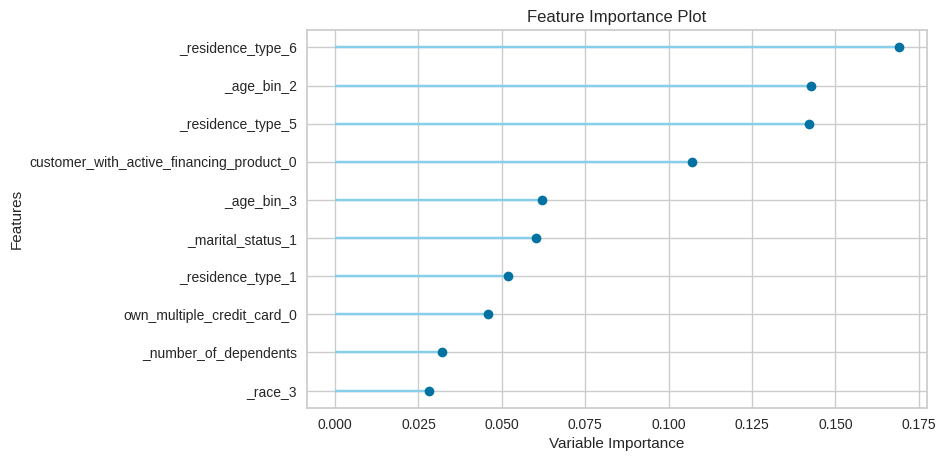

In [349]:
# Feature importance from model POV
plot_model(xgboost, plot='feature')

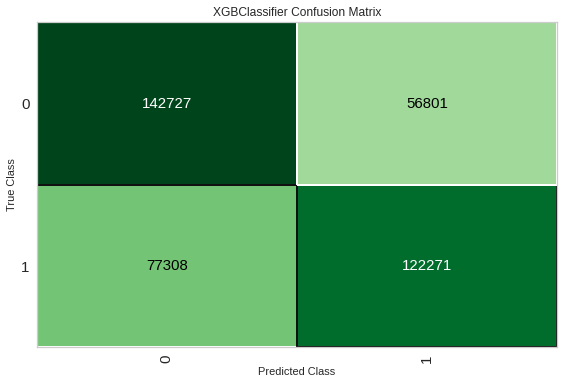

In [350]:
# confusion_matrix
plot_model(xgboost, plot='confusion_matrix')

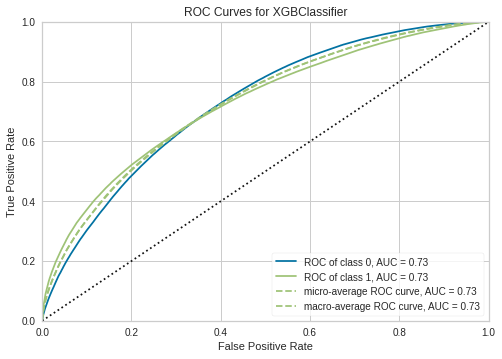

In [352]:
# Area under the curve (AUC)
plot_model(xgboost, plot='auc')

In [353]:
## Further model can be tune using below function
# tuned_xgboost = tune_model(xgboost,fold = 2)

# Recommendation

## Additional Feature's

    Some additional data will help to enrich the model. I'll recommend to fit below data into the model 

    -- Customer's monthly income information
    -- Cedit bureau data with past credit & re-payment history, which will show the customer financial status with other organization as well.
    -- Customer transaction history, it'll help to segment the customer according to their spending pattern.
    -- Customer bill (telco, wifi, water etc.) payment history
    

## Production Pipeline

   On high level below can be the pipeline for the model and the application
   
   <img src="markdown/production_pipeline.png" width=1000 height=1000 />